In [1]:
import os
os.chdir("..")

import torch
import networkx as nx
from math import comb
from hbar.hamiltonian import Hamiltonian
from hbar.utils import H2M, H2P
from hbar.krylov import step

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
from tqdm import tqdm

import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
device = torch.device('cpu') # 'cpu', 'cuda'

In [3]:
n_u, n_d, L0, L1 = 2, 2, 4, 4
L = L0 * L1
N_u = comb(L, n_u)
N_d = comb(L, n_d)
print(f"(u {N_u:_}, d {N_d:_}, ud {N_u * N_d:_})")

(u 120, d 120, ud 14_400)


In [4]:
adj_mat = torch.tensor(nx.adjacency_matrix(nx.grid_2d_graph(L0, L1)).toarray(), device=device)
potential = torch.zeros((L,), device=device, dtype=torch.float32)
H = Hamiltonian(n_u, n_d, adj_mat, potential, device=device, t=1, u=1, v=1)

In [5]:
ic_up = torch.tensor([
    [1,0,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,1]
], device=device).view(-1)
ic_down = torch.tensor([
    [0,0,0,1],
    [0,0,0,0],
    [0,0,0,0],
    [1,0,0,0]
], device=device).view(-1)
ic_up = (ic_up * (1 << torch.arange(L, device=device))).sum()
ic_up = (H.up == ic_up).nonzero()[0,0]
ic_down = (ic_down * (1 << torch.arange(L, device=device))).sum()
ic_down = (H.down == ic_down).nonzero()[0,0]

In [16]:
dt = 0.25
tmax = 50
nsteps = round(tmax/dt)
t = np.linspace(0, tmax, nsteps)

psi0 = torch.zeros((N_u, N_d), dtype=torch.complex128).to(device)
psi0[ic_up, ic_down] = 1

psi = psi0.clone().to(device)
p_up_log = torch.zeros((nsteps, N_u), device=device)
p_down_log = torch.zeros((nsteps, N_d), device=device)
for j in tqdm(range(nsteps)):
    p = torch.abs(psi)**2
    p_up_log[j] = torch.sum(p, dim=1)
    p_down_log[j] = torch.sum(p, dim=0)
    psi = step(psi, H, dt, K=10)

f_up_log = torch.sum(((H.up[None, :, None] & (1 << H.site_idx[None, None, :])) != 0) * p_up_log[:, :, None], dim=1).cpu()
f_down_log = torch.sum(((H.down[None, :, None] & (1 << H.site_idx[None, None, :])) != 0) * p_down_log[:, :, None], dim=1).cpu()

100%|██████████| 200/200 [00:06<00:00, 30.55it/s]


In [17]:
H.E(psi0) - H.E(psi)

-6.288372600415926e-16

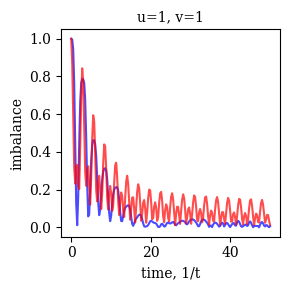

In [20]:
def quad_info(fu, fd):
    diag_u = fu[:, :L0//2, :L1//2].sum(dim=(1,2)) + fu[:, L0//2:, L1//2:].sum(dim=(1,2))
    diag_d = fd[:, :L0//2, :L1//2].sum(dim=(1,2)) + fd[:, L0//2:, L1//2:].sum(dim=(1,2))
    imb_s = (diag_u - diag_d) / (diag_u + diag_d)
    imb_f = (fu.std(dim=(1,2)) + fd.std(dim=(1,2)))/2
    return imb_s, imb_f/imb_f.max()

fig, ax = plt.subplots(1, 1, figsize=(3,3))
imb_s, imb_f = quad_info(fu, fd)
ax.plot(t, torch.abs(imb_s), color='blue', alpha=0.7)
ax.plot(t, torch.abs(imb_f), color='red', alpha=0.7)
ax.set_xlabel("time, 1/t")
ax.set_ylabel("imbalance")
# ax.set_ylim(0.001, 2)
ax.set_title(f'u={1}, v={1}', size=10)
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.tight_layout()
plt.show()

In [21]:
# fu, fd = f_up_log.cpu().view(nsteps, L0, L1), f_down_log.cpu().view(nsteps, L0, L1)

# vmax = 0.1
# fig, ax = plt.subplots(1, 1, figsize=(3,3))
# im_u = ax.matshow(fu[0], cmap='Reds', alpha=1, vmin=0, vmax=vmax)
# im_d = ax.matshow(fd[0], cmap='Blues', alpha=0.5, vmin=0, vmax=vmax)
# ax.set_xticks([])
# ax.set_yticks([])

# def update(frame):
#     im_u.set_array(fu[frame])
#     im_d.set_array(fd[frame])
#     return im_u, im_d

# ani = animation.FuncAnimation(fig, update, frames=nsteps, interval=50)
# plt.close(fig)

# HTML(ani.to_jshtml())